In [63]:
!pip install xgboost

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler


In [218]:
# Load the data
file_path = '/content/BangloreDATA.csv'
data = pd.read_csv(file_path)


print(data.head())


   YEAR  MO  DY  WS2M    T2M     TS  T2M_RANGE  T2M_MAX  T2M_MIN  PRECTOTCORR  \
0  1981   1   1  2.85  21.00  22.26      14.48    29.09    14.62         0.00   
1  1981   1   2  1.91  21.53  23.05      13.55    29.12    15.58         0.42   
2  1981   1   3  2.41  21.14  22.53      13.03    29.07    16.04         0.86   
3  1981   1   4  2.23  20.84  22.24      14.09    29.33    15.24         0.00   
4  1981   1   5  1.73  20.61  22.21      16.45    30.23    13.77         0.00   

    RH2M   QV2M     PS  WS10M  WS50M   WD50M   WD10M  RainToday  RainTomorrow  
0  68.69  10.80  91.90   4.05   5.69   83.75   83.81          0             1  
1  69.00  11.17  91.87   2.77   4.12   86.19   87.00          1             1  
2  68.69  10.86  91.88   3.48   5.16   75.94   76.75          1             0  
3  64.00   9.70  91.90   3.26   4.94   85.88   87.00          0             0  
4  62.44   9.09  91.94   2.59   4.11  102.56  104.31          0             0  


In [219]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15706 entries, 0 to 15705
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   YEAR          15706 non-null  int64  
 1   MO            15706 non-null  int64  
 2   DY            15706 non-null  int64  
 3   WS2M          15706 non-null  float64
 4   T2M           15706 non-null  float64
 5   TS            15706 non-null  float64
 6   T2M_RANGE     15706 non-null  float64
 7   T2M_MAX       15706 non-null  float64
 8   T2M_MIN       15706 non-null  float64
 9   PRECTOTCORR   15706 non-null  float64
 10  RH2M          15706 non-null  float64
 11  QV2M          15706 non-null  float64
 12  PS            15706 non-null  float64
 13  WS10M         15706 non-null  float64
 14  WS50M         15706 non-null  float64
 15  WD50M         15706 non-null  float64
 16  WD10M         15706 non-null  float64
 17  RainToday     15706 non-null  int64  
 18  RainTomorrow  15706 non-nu

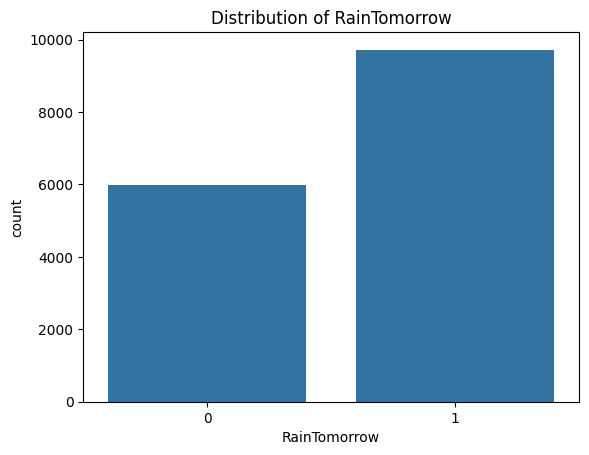

In [ ]:

sns.countplot(x='RainTomorrow', data=data)
plt.title('Distribution of RainTomorrow')
plt.show()


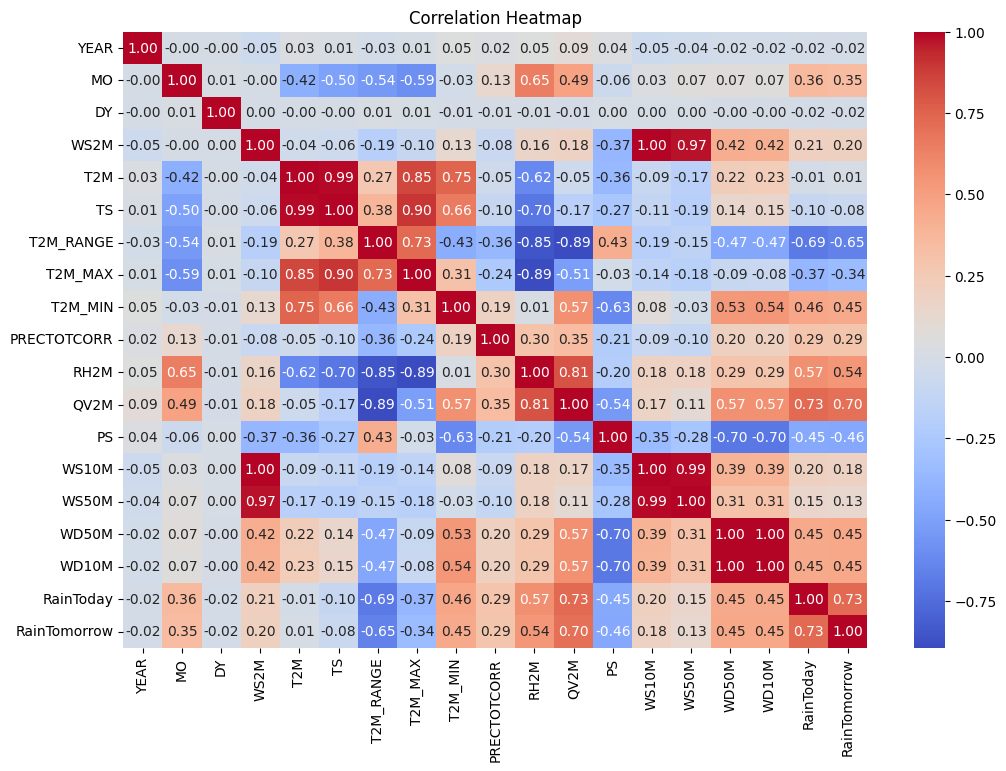

In [ ]:

plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [222]:
# Correlation with RainTomorrow
correlation_matrix = data.corr()
target_correlation = correlation_matrix['RainTomorrow'].sort_values(ascending=False)

# Print the top 5 most correlated features
print("Top correlated features with RainTomorrow:")
print(target_correlation.head(6))


Top correlated features with RainTomorrow:
RainTomorrow    1.000000
RainToday       0.727364
QV2M            0.698980
RH2M            0.538817
WD50M           0.454320
WD10M           0.453894
Name: RainTomorrow, dtype: float64


In [ ]:

features = ['WS2M', 'T2M', 'TS', 'T2M_RANGE', 'T2M_MAX', 'T2M_MIN',
            'PRECTOTCORR', 'RH2M', 'QV2M', 'PS', 'WS10M', 'WS50M',
            'WD50M', 'WD10M', 'RainToday']
target = 'RainTomorrow'

X = data[features]
y = data[target]

In [224]:
data.rename(columns={'Yr': 'YEAR', 'MO': 'Month', 'DY': 'Day',"PRECTOTCORR":"Precipitation"}, inplace=True)


In [225]:
data['Date'] = pd.to_datetime(data[['YEAR', 'Month', 'Day']])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [226]:
features_to_lag = ['RainToday', 'QV2M', 'RH2M', 'WD50M', 'WD10M']

In [227]:
num_lags = 7

In [ ]:
for feature in features_to_lag:
    for lag in range(1, num_lags + 1):
        data[f'{feature}_lag{lag}'] = data[feature].shift(lag)


data = data.dropna().reset_index(drop=True)

In [ ]:

X = data.drop(columns=['RainTomorrow'])
y = data['RainTomorrow']

print(f"X shape: {X.shape}, y shape: {y.shape}")

train_size = int(0.8 * len(X))

X_train_full, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train_full, y_test = y.iloc[:train_size], y.iloc[train_size:]

X shape: (15699, 53), y shape: (15699,)


In [230]:
print(f"Train shape: {X_train_full.shape}, Test shape: {X_test.shape}")
print(f"Train shape: {y_train_full.shape}, Test shape: {y_test.shape}")

Train shape: (12559, 53), Test shape: (3140, 53)
Train shape: (12559,), Test shape: (3140,)


In [231]:
train_size = int(0.8 * len(X_train_full))

X_train, X_validation = X_train_full.iloc[:train_size], X_train_full.iloc[train_size:]
y_train, y_validation = y_train_full.iloc[:train_size], y_train_full.iloc[train_size:]

In [232]:
print(f"Train shape: {X_train.shape}, Validation shape: {X_validation.shape}")
print(f"Train shape: {y_train.shape}, Validation shape: {y_validation.shape}")

Train shape: (10047, 53), Validation shape: (2512, 53)
Train shape: (10047,), Validation shape: (2512,)


In [233]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


xgb_model.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_validation_scaled, y_validation)], 
    verbose=True  
)


[0]	validation_0-logloss:0.61881
[1]	validation_0-logloss:0.57039
[2]	validation_0-logloss:0.53144
[3]	validation_0-logloss:0.49889
[4]	validation_0-logloss:0.47111
[5]	validation_0-logloss:0.44640
[6]	validation_0-logloss:0.42704
[7]	validation_0-logloss:0.40922
[8]	validation_0-logloss:0.39397
[9]	validation_0-logloss:0.38172
[10]	validation_0-logloss:0.37055
[11]	validation_0-logloss:0.36086
[12]	validation_0-logloss:0.35410
[13]	validation_0-logloss:0.34718
[14]	validation_0-logloss:0.34157
[15]	validation_0-logloss:0.33600
[16]	validation_0-logloss:0.33171
[17]	validation_0-logloss:0.32886
[18]	validation_0-logloss:0.32514
[19]	validation_0-logloss:0.32312
[20]	validation_0-logloss:0.32027
[21]	validation_0-logloss:0.31909
[22]	validation_0-logloss:0.31719
[23]	validation_0-logloss:0.31527
[24]	validation_0-logloss:0.31351
[25]	validation_0-logloss:0.31252
[26]	validation_0-logloss:0.31045
[27]	validation_0-logloss:0.31035
[28]	validation_0-logloss:0.30915
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [246]:
y_test_pred = xgb_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(test_accuracy)

0.8726114649681529


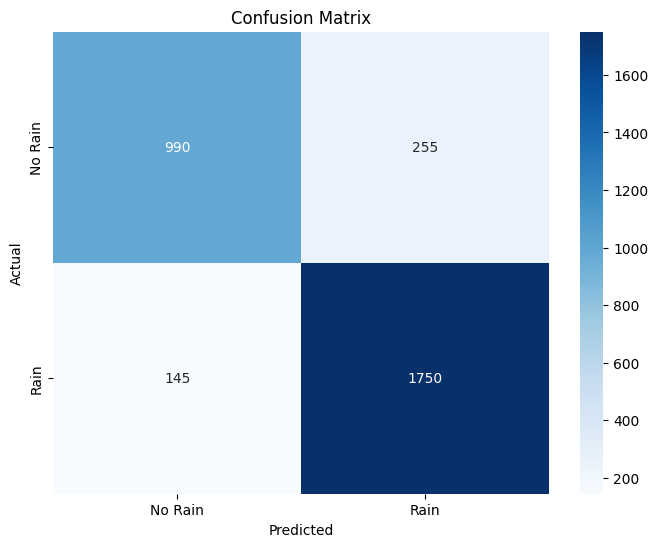

In [247]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain', 'Rain'], yticklabels=['No Rain', 'Rain'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [248]:
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.83      1245
           1       0.87      0.92      0.90      1895

    accuracy                           0.87      3140
   macro avg       0.87      0.86      0.86      3140
weighted avg       0.87      0.87      0.87      3140



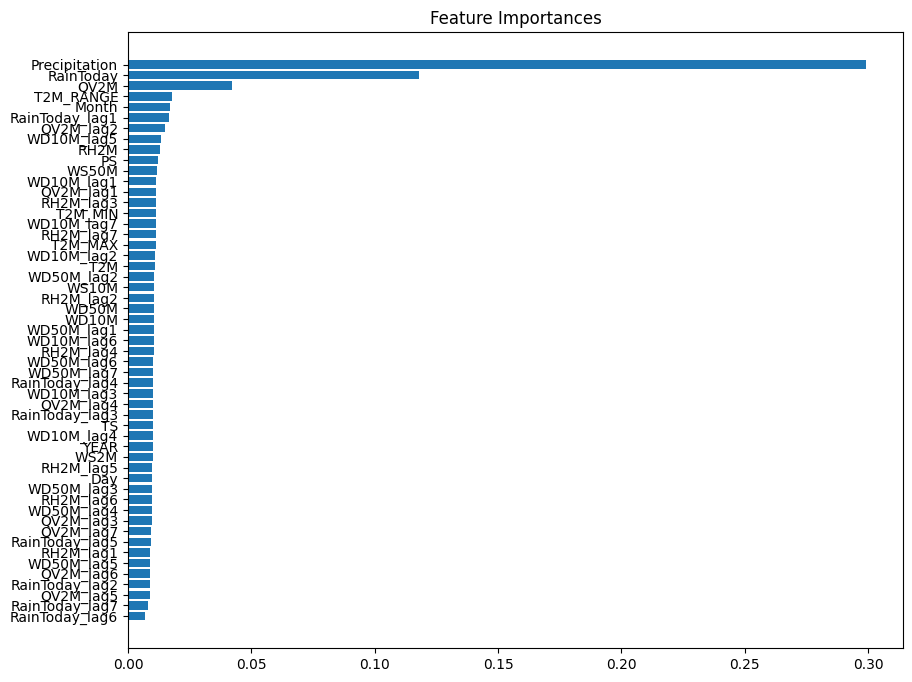

Test Accuracy: 0.87


In [249]:
feature_importances = xgb_model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.title('Feature Importances')
plt.show()
print(f"Test Accuracy: {test_accuracy:.2f}")

In [250]:
import pickle

# Save the trained model to a file
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

print("Model saved as 'xgb_model.pkl'")


Model saved as 'xgb_model.pkl'
